<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/notebooks/evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
class_names = [
    "lake",
    "settlement",
    "shrub land",
    "grass land",
    "homogenous forest",
    "agriculture1 (with vegetation)",
    "agriculture2 (without vegetation)",
    "open area",
    "clove plantation",
    "mixed forest1",
    "mixed forest2",
    "rice field1",
    "rice field2",
    "rice field3",
    "mixed garden",
    "grass land2",
    "grass land3",
    "mixed garden2",
    "agroforestry",
    "clouds",
]


1. reshape the input image to the size of label
2. create boolean mask
boolean_mask = label_array != 0
3. apply boolean mask to resized prediction
new_predict = np.where(boolean_mask,resized_prediction_array,0)
4. send the label_array and new_predict into the compute_metrics

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install rasterio

In [16]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import time
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [4]:
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'

In [5]:
def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)

    with rasterio.open(tiff) as src:
        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)

    return clip_image

def tensorify_image(image):
    ## resizing and process input funciton condensed into one.
    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    return tensor_image


def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor


def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image


def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    all_tiles = tf.reshape(tiles, [nrows * ncols, TILE_HT, TILE_WD, CHANNELS])
    ordered_tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    return ordered_tiles, all_tiles, fullimg.shape



def stitch_segmentation_patches(segmentation_patches, dims, PATCH_HEIGHT, PATCH_WIDTH):
    height, width = dims[0], dims[1]
    num_rows, num_cols = segmentation_patches.shape[:2]

    # Convert TensorFlow tensor to NumPy array
    segmentation_patches_np = segmentation_patches.numpy()

    stitched_array = np.zeros((height, width), dtype=int)

    # Reshape the segmentation_patches array
    segmentation_patches_reshaped = segmentation_patches_np.reshape(
        (num_rows, num_cols, PATCH_HEIGHT, PATCH_WIDTH)
    )
    print("segmentation_patches_reshaped.shape", segmentation_patches_reshaped.shape)

    # Calculate the indices for stitching
    row_indices_patch = np.arange(0, height, PATCH_HEIGHT)
    col_indices_patch = np.arange(0, width, PATCH_WIDTH)
    print("row_indices_patch", row_indices_patch.shape)
    print("col_indices_patch", col_indices_patch.shape)

    # Use nested loops to stitch patches into the final array
    for i in range(num_rows):
        for j in range(num_cols):
            row_start = row_indices_patch[i]
            col_start = col_indices_patch[j]
            row_end = row_start + PATCH_HEIGHT
            col_end = col_start + PATCH_WIDTH

            stitched_array[
                row_start:row_end, col_start:col_end
            ] = segmentation_patches_reshaped[i, j]

    print("stitched_array", stitched_array.shape)
    return stitched_array


def prediction_function_img(test_image_path):
    image = clip_tiff(test_image_path)
    new_image = tensorify_image(image)
    normalized_image = bandwise_normalize(new_image)
    display_patches, inference_patches, dims = tile_image(
        normalized_image, IMAGE_CHANNELS, PATCH_HEIGHT, PATCH_WIDTH
    )
    print("dims", dims)
    start_time = time.time()
    predictions = model.predict(inference_patches, batch_size=2048)
    end_time_pred = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time_pred - start_time

    # Print the elapsed time
    print(f"Time taken for predictions: {elapsed_time} seconds")

    logits = predictions

    # Set values of class 0 to a very large negative number
    mask = tf.one_hot(
        0, depth=23, on_value=float("-inf"), off_value=0, dtype=tf.float32
    )
    logits_with_mask = logits + mask

    # Perform argmax along the last axis (axis=-1)
    argmax_result = tf.argmax(logits_with_mask, axis=-1)

    tiles = display_patches
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    segmentation_patches = tf.reshape(
        argmax_result, [nrows, ncols, PATCH_HEIGHT, PATCH_WIDTH]
    )

    stitched_array = stitch_segmentation_patches(
        segmentation_patches, dims, PATCH_HEIGHT, PATCH_WIDTH
    )

    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time_stitch = end_time - start_time

    # Print the elapsed time
    print(f"Time taken including stitching: {elapsed_time_stitch} seconds")

    return stitched_array


In [7]:
model_path = '/content/model_patch_h8_w8_batch_32.hdf5'

IMAGE_CHANNELS = 8  # 8 bands images as input

model = keras.models.load_model(model_path)
input_shape = model.layers[0].input_shape

PATCH_HEIGHT = input_shape[0][-3]
PATCH_WIDTH = input_shape[0][-2]

test_image_path = '/content/gdrive/MyDrive/exp/other images/test_folder/area2_0803_2022_8bands.tif'

predicted_array = prediction_function_img(test_image_path)

dims (3696, 4584, 8)
130/130 [==============================] - 3s 9ms/step
Time taken for predictions: 6.710364818572998 seconds
segmentation_patches_reshaped.shape (462, 573, 8, 8)
row_indices_patch (462,)
col_indices_patch (573,)
stitched_array (3696, 4584)
Time taken including stitching: 10.331306219100952 seconds


In [8]:
label_path = '/content/gdrive/MyDrive/exp/label/image_extent_mask_1123.tif'
ground_truth = clip_tiff(label_path)

In [9]:
def resize_img(image,label):
  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])
  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.expand_dims(tensor_image,-1)
    #tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])
    #tensor_label = tf.expand_dims(tensor_label,-1)


    if tensor_label.shape != tensor_image.shape:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    tensor_image = tf.squeeze(tensor_image)
    tensor_label = tf.squeeze(tensor_label)

    return tensor_image.numpy().astype(int), tensor_label.numpy().astype(int)

In [10]:
resized_predicted_array, new_ground_truth = process_input(predicted_array, ground_truth)

In [11]:
new_boolean_mask = new_ground_truth != 0

In [12]:
new_boolean_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [22]:
new_predict = np.where(new_boolean_mask,resized_predicted_array,0)

In [23]:
flattened_array = np.ravel(new_predict).astype(int)
result = np.bincount(flattened_array)

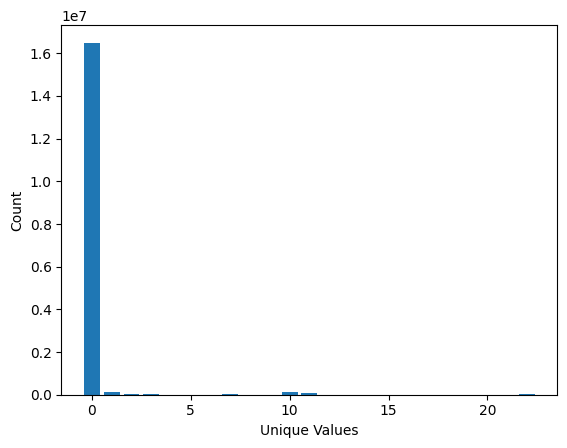

In [24]:
# Generate x-axis values (unique integers in the input array)
x_values = np.arange(len(result))

# Create a bar plot
plt.bar(x_values, result, align='center')

# Label the axes
plt.xlabel('Unique Values')
plt.ylabel('Count')

# Show the plot
plt.show()

In [41]:
unique_values = np.unique(new_predict)

In [44]:
unique_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       20, 22])

In [43]:
len(unique_values)

19

In [37]:
unique_values_ground_truth = np.unique(new_ground_truth)

In [39]:
unique_values_ground_truth

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 20, 21, 22])

In [38]:
len(unique_values_ground_truth)

21

In [20]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''

  class_wise_iou = []
  class_wise_dice_score = []
  class_wise_accuracy = []
  class_wise_precision = []
  class_wise_recall = []

  smoothening_factor = 0.00001

  for i in np.unique(y_true)[1:]:
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

    # Accuracy
    accuracy = np.sum((y_pred == i) & (y_true == i)) / np.sum(y_true == i)
    class_wise_accuracy.append(accuracy)

    # Precision
    precision = intersection / (y_pred_area + smoothening_factor)
    class_wise_precision.append(precision)

    # Recall
    recall = intersection / (y_true_area + smoothening_factor)
    class_wise_recall.append(recall)

  # Mean IOU
  mean_iou = np.mean(class_wise_iou)

  return class_wise_iou, class_wise_dice_score,class_wise_accuracy, class_wise_precision, class_wise_recall, mean_iou

In [25]:
class_names = [
    "lake",
    "settlement",
    "shrub land",
    "grass land",
    "homogenous forest",
    "agriculture1 (with vegetation)",
    "agriculture2 (without vegetation)",
    "open area",
    "clove plantation",
    "mixed forest1",
    "mixed forest2",
    "rice field1",
    "rice field2",
    "rice field3",
    "mixed garden",
    "grass land2",
    "grass land3",
    "mixed garden2",
    "agroforestry",
    "clouds",
]


In [26]:
# compute class-wise metrics
class_wise_iou, class_wise_dice_score, class_wise_accuracy, class_wise_precision, class_wise_recall, mean_iou = compute_metrics(new_ground_truth, new_predict)


In [28]:
mean_iou

0.15763501392713128

In [ ]:
class_wise_iou

In [27]:
# print IOU for each class
for idx, iou in enumerate(class_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

lake           0.9797916792437278 
settlement     0.5958236660808243 
shrub land     0.0476620006322478 
grass land     0.06061093398615605 
homogenous forest0.21305182386075883 
agriculture1 (with vegetation)0.10794832689304067 
agriculture2 (without vegetation)0.18143313073314005 
open area      1.0482180183624946e-08 
clove plantation0.00020128925100514368 
mixed forest1  0.32165169654938397 
mixed forest2  0.3056850539259614 
rice field1    1.6393442354205864e-08 
rice field2    0.0008952573838512592 
rice field3    0.022535213770716482 
mixed garden   3.4387895342545063e-09 
grass land2    5.61167224684808e-09 
grass land3    2.3474177852718834e-08 
mixed garden2  0.14878777956029926 
agroforestry   5.0251253756218405e-08 
clouds         0.1666223170199968 


In [29]:
# print the dice score for each class
for idx, dice_score in enumerate(class_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

lake           0.9897927034941342 
settlement     0.7467287005679765 
shrub land     0.09098736161070793 
grass land     0.11429437909004944 
homogenous forest0.3512658235520915 
agriculture1 (with vegetation)0.19486166364651844 
agriculture2 (without vegetation)0.30714075321326945 
open area      2.0964360367249892e-08 
clove plantation0.00040249748399829194 
mixed forest1  0.48674200230851816 
mixed forest2  0.4682370423451814 
rice field1    3.278688470841173e-08 
rice field2    0.0017889132339246126 
rice field3    0.04407713988460521 
mixed garden   6.877579068509013e-09 
grass land2    1.122334449369616e-08 
grass land3    4.694835570543767e-08 
mixed garden2  0.2590344055232229 
agroforestry   1.0050250751243681e-07 
clouds         0.2856491164634767 


In [45]:
from sklearn.metrics import confusion_matrix

# Flatten the arrays to 1D
ground_truth_flat = new_ground_truth.flatten()
predictions_flat = new_predict.flatten()

# Create the confusion matrix
conf_matrix = confusion_matrix(ground_truth_flat, predictions_flat, labels = np.unique(new_ground_truth)[1:])


In [46]:
import seaborn as sns

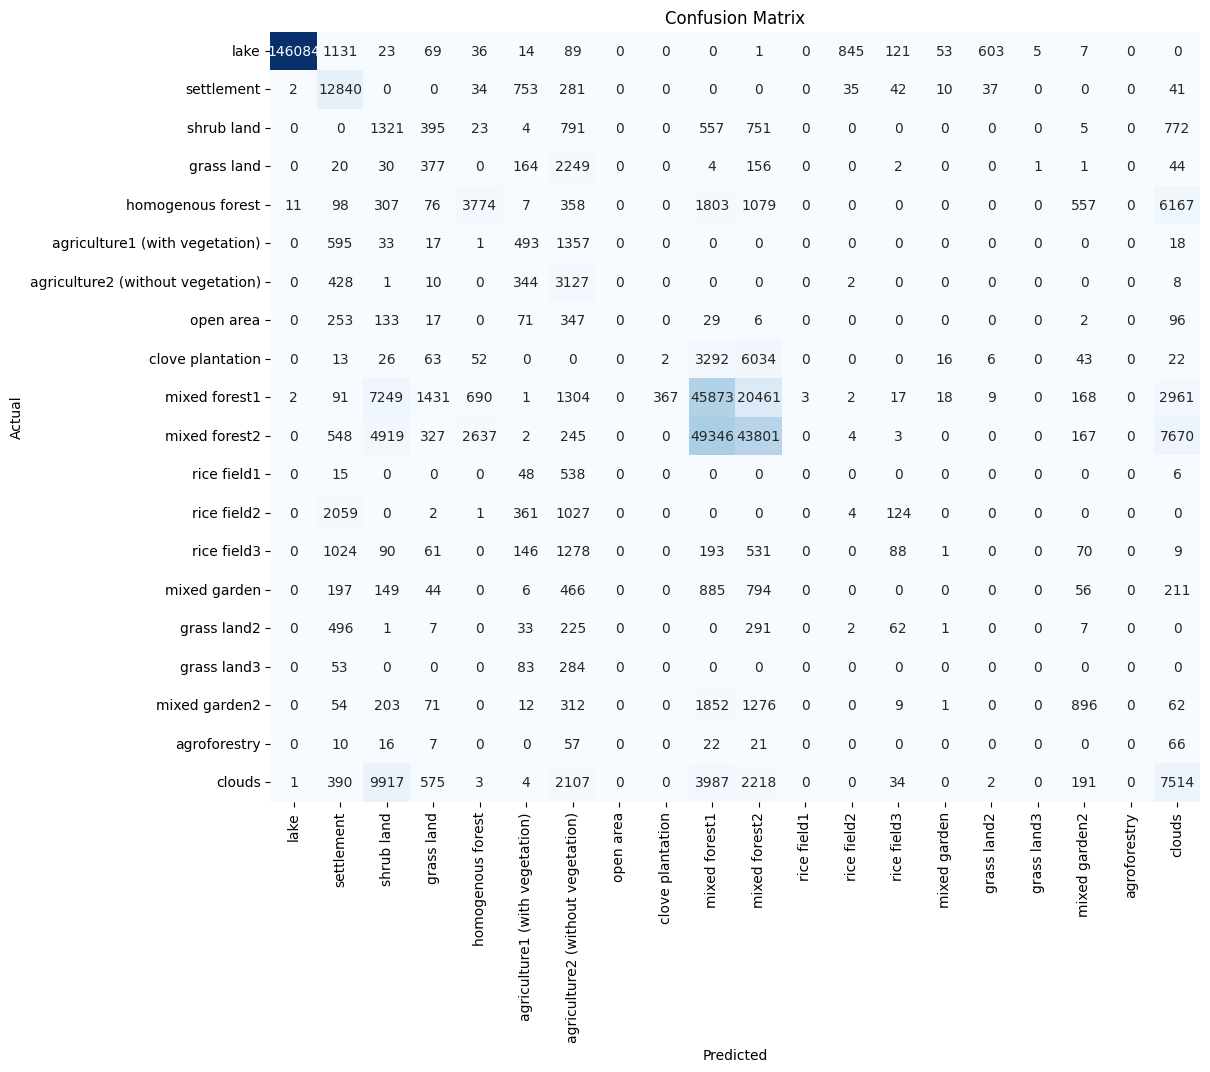

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

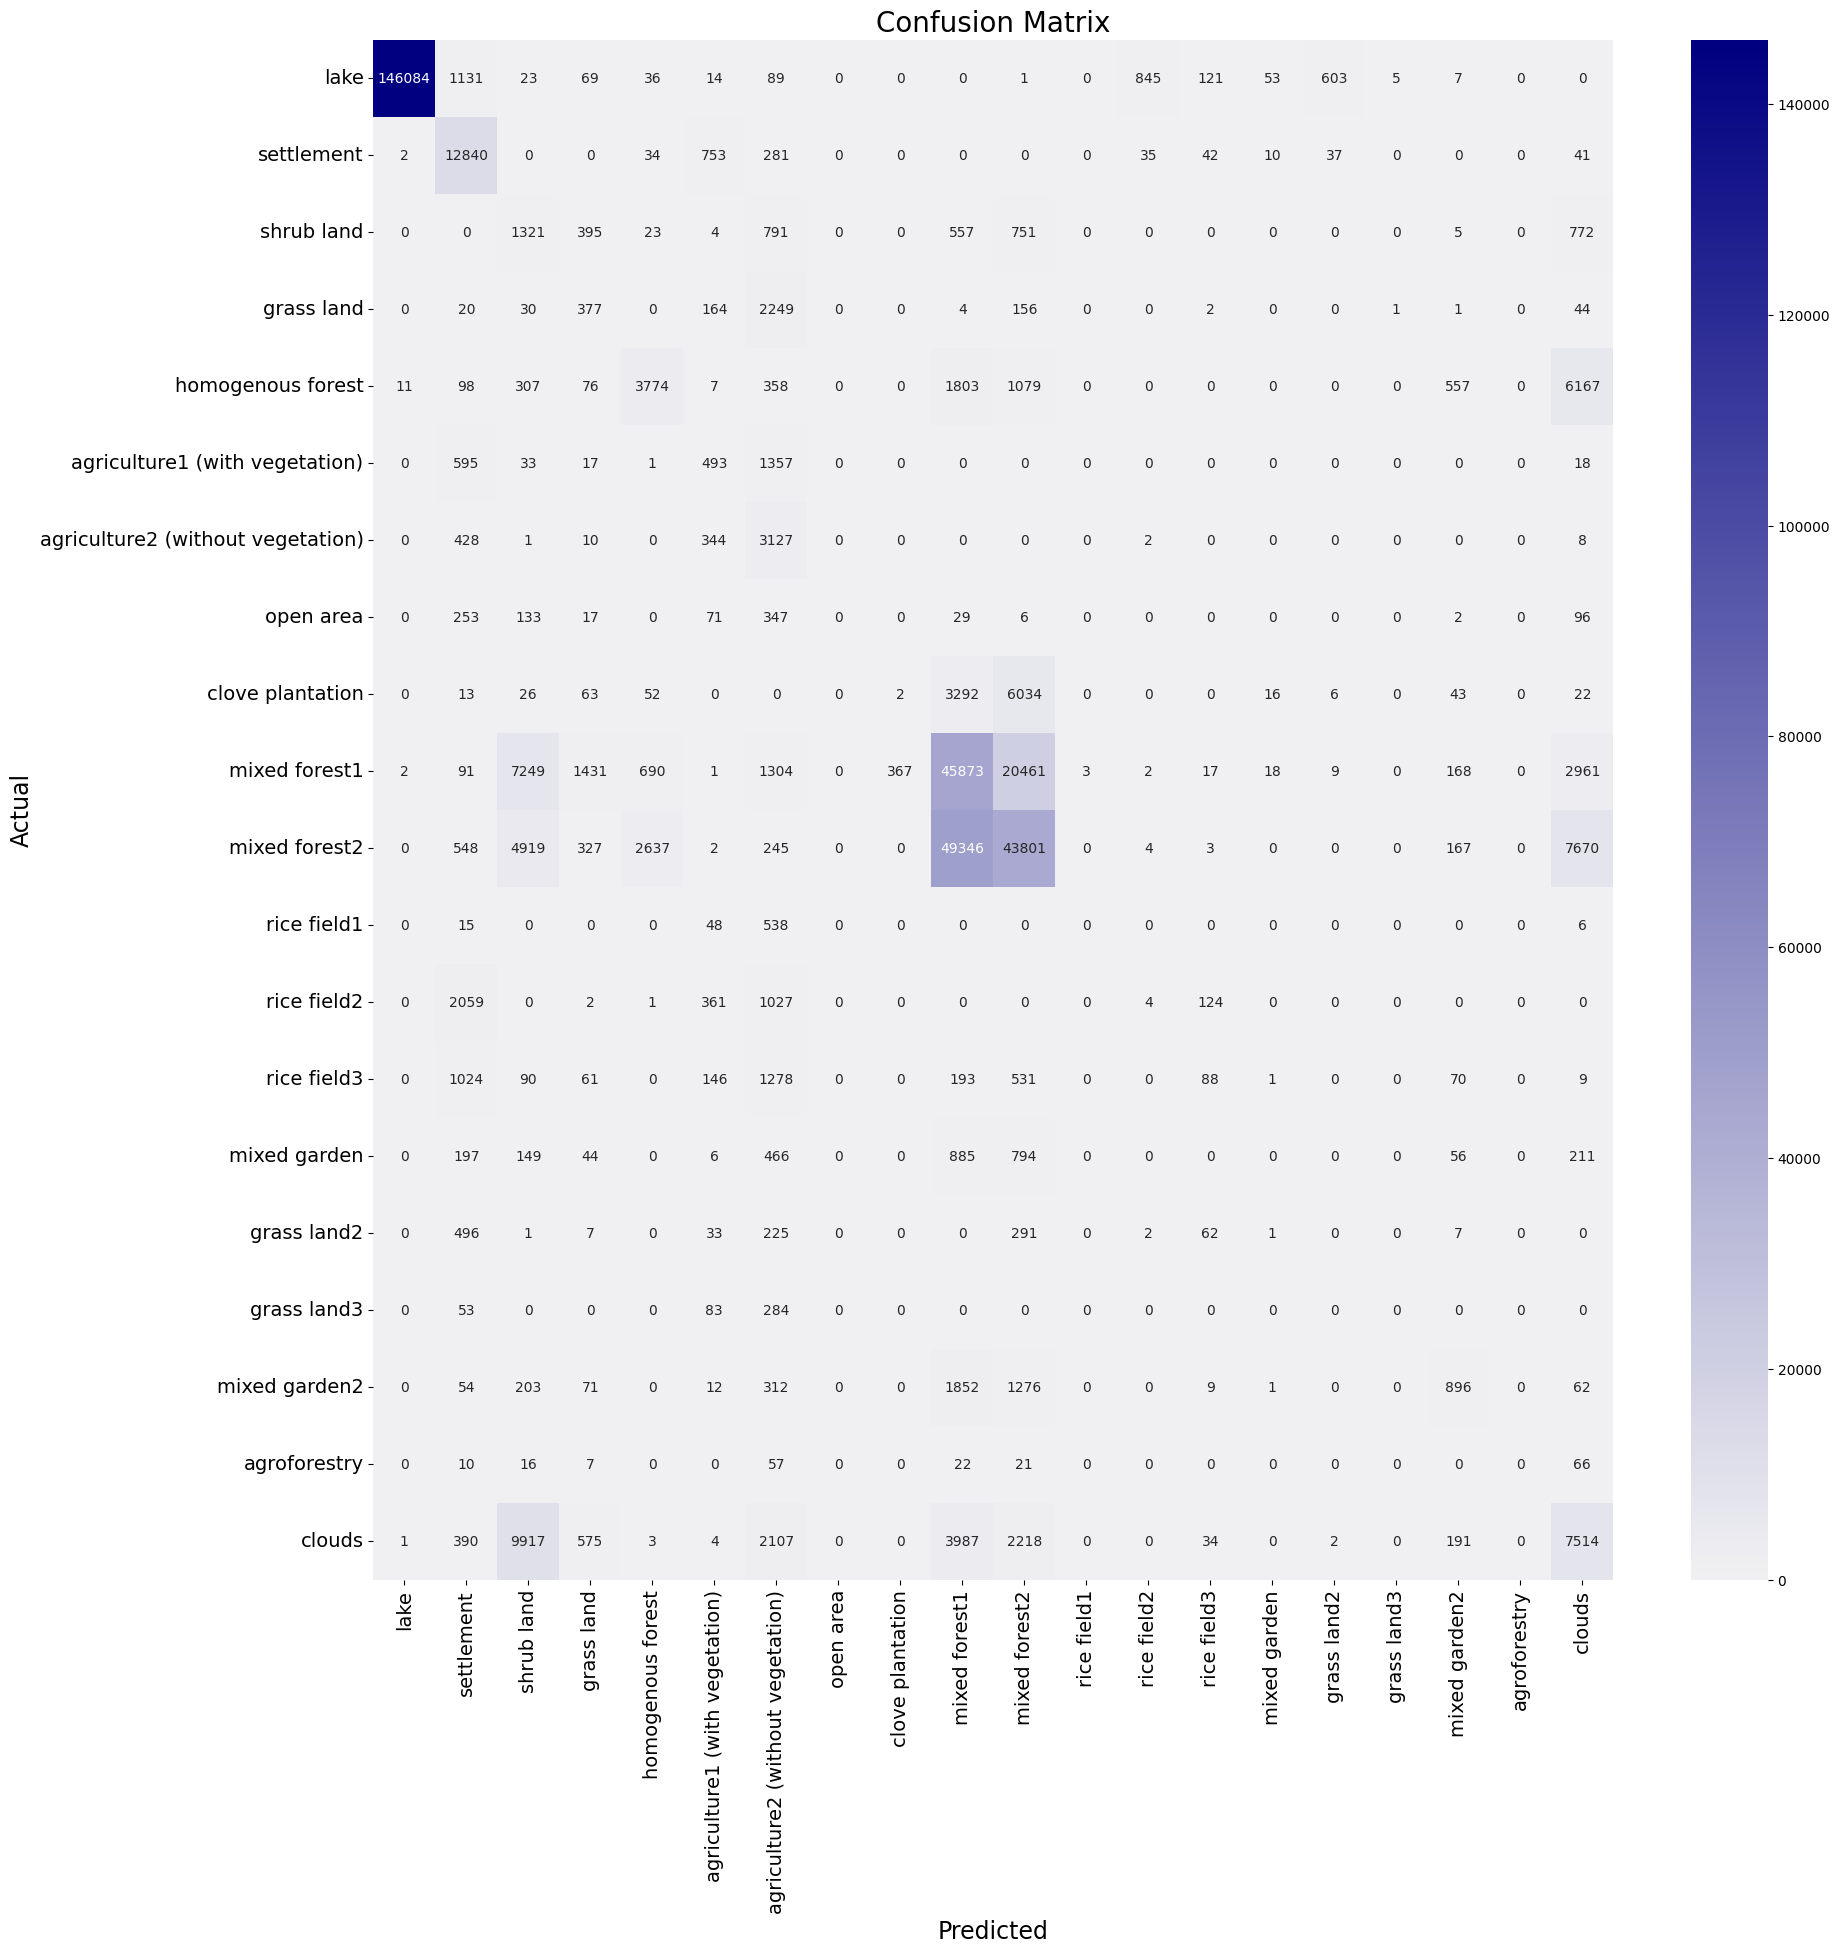

In [52]:
color_palette = sns.light_palette("navy", as_cmap=True)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color_palette, cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('Actual', fontsize=17)
plt.title('Confusion Matrix', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Provided normalized colors array
normalized_colors_array = np.array([
    [0.01960784, 0.01960784, 0.90196078],
    [0.74509804, 0.23529412, 0.05882353],
    [0.25490196, 0.94117647, 0.49019608],
    [0.41176471, 0.78431373, 0.37254902],
    [0.11764706, 0.45098039, 0.03921569],
    [1.        , 0.76862745, 0.13333333],
    [0.43137255, 0.33333333, 0.01960784],
    [0.92156863, 0.92156863, 0.8627451 ],
    [0.47058824, 0.84705882, 0.18431373],
    [0.32941176, 0.55686275, 0.50196078],
    [0.32941176, 0.55686275, 0.50196078],
    [0.19607843, 1.        , 0.84313725],
    [0.19607843, 1.        , 0.84313725],
    [0.19607843, 1.        , 0.84313725],
    [0.75686275, 1.        , 0.        ],
    [0.41176471, 0.78431373, 0.37254902],
    [0.41176471, 0.78431373, 0.37254902],
    [0.75686275, 1.        , 0.        ],
    [1.        , 0.19607843, 0.7254902 ],
    [1.        , 1.        , 1.        ]
])

# Create a Seaborn color palette
colors = sns.color_palette(normalized_colors_array)




In [ ]:
colors

[(0.01960784, 0.01960784, 0.90196078),
 (0.74509804, 0.23529412, 0.05882353),
 (0.25490196, 0.94117647, 0.49019608),
 (0.41176471, 0.78431373, 0.37254902),
 (0.11764706, 0.45098039, 0.03921569),
 (1.0, 0.76862745, 0.13333333),
 (0.43137255, 0.33333333, 0.01960784),
 (0.92156863, 0.92156863, 0.8627451),
 (0.47058824, 0.84705882, 0.18431373),
 (0.32941176, 0.55686275, 0.50196078),
 (0.32941176, 0.55686275, 0.50196078),
 (0.19607843, 1.0, 0.84313725),
 (0.19607843, 1.0, 0.84313725),
 (0.19607843, 1.0, 0.84313725),
 (0.75686275, 1.0, 0.0),
 (0.41176471, 0.78431373, 0.37254902),
 (0.41176471, 0.78431373, 0.37254902),
 (0.75686275, 1.0, 0.0),
 (1.0, 0.19607843, 0.7254902),
 (1.0, 1.0, 1.0)]

In [ ]:
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

lake -- (0.01960784, 0.01960784, 0.90196078)
settlement -- (0.74509804, 0.23529412, 0.05882353)
shrub land -- (0.25490196, 0.94117647, 0.49019608)
grass land -- (0.41176471, 0.78431373, 0.37254902)
homogenous forest -- (0.11764706, 0.45098039, 0.03921569)
agriculture1 (with vegetation) -- (1.0, 0.76862745, 0.13333333)
agriculture2 (without vegetation) -- (0.43137255, 0.33333333, 0.01960784)
open area -- (0.92156863, 0.92156863, 0.8627451)
clove plantation -- (0.47058824, 0.84705882, 0.18431373)
mixed forest1 -- (0.32941176, 0.55686275, 0.50196078)
mixed forest2 -- (0.32941176, 0.55686275, 0.50196078)
rice field1 -- (0.19607843, 1.0, 0.84313725)
rice field2 -- (0.19607843, 1.0, 0.84313725)
rice field3 -- (0.19607843, 1.0, 0.84313725)
mixed garden -- (0.75686275, 1.0, 0.0)
grass land2 -- (0.41176471, 0.78431373, 0.37254902)
grass land3 -- (0.41176471, 0.78431373, 0.37254902)
mixed garden2 -- (0.75686275, 1.0, 0.0)
agroforestry -- (1.0, 0.19607843, 0.7254902)
clouds -- (1.0, 1.0, 1.0)
